# Plotting 2D Gradient Vector Field of Electrostatic Density 

## Introduction
This notebook is meant to visualize the 2 dimensional gradient vector field of the electronic density of the provided molecule

## Dependencies

1. [numpy](https://numpy.org/doc/stable/)
2. [matplotlib ](https://matplotlib.org/stable/contents.html)
3. [Chemtools](https://chemtools.org/usr_doc_installation.html) 

## Obtaining XYZ coordinates

We use the chemtools call `mol.coordinates` to obtain the XYZ cartesian coordinates of our molecule, in this example, dichloropyrimidine. 

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# mpl_toolkits.mplot3d import Axes3D

from chemtools import Molecule


mol = Molecule.from_file("dichloropyridine26_q+0.fchk")
coord = mol.coordinates

print("XYZ Coordinates: ")
print(coord)





User:           woodn
Machine info:   Linux woodn 5.13.10-arch1-1 #1 SMP PREEMPT Thu, 12 Aug 2021 21:59:14 +0000 x86_64
Time:           2021-08-17T22:55:09.916226
Python version: 2.7.18 |Anaconda, Inc.| (default, Jun  4 2021, 14:47:46) [GCC 7.3.0]
HORTON version: 2.1.0
Current Dir:    /home/woodn/GSOC/projects/chemtools/examples/plotting
Command line:   /home/woodn/.conda/envs/chemtools/lib/python2.7/site-packages/ipykernel_launcher.py
                -f
                /home/woodn/.local/share/jupyter/runtime/kernel-eb9fe2a4-0233-4cd8-be0c-79316ce70da4
                .json
HORTON module:  /home/woodn/.conda/envs/chemtools/lib/python2.7/site-packages/horton/log.pyc

Initialized: <horton.gbasis.cext.GOBasis object at 0x7fbcba2c5590>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S

/home/woodn/GSOC/programs/chemtools/chemtools/chemtools/outputs/plot.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/woodn/.conda/envs/chemtools/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/woodn/.conda/envs/chemtools/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/woodn/.conda/envs/chemtools/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/woodn/.conda/envs/chemtools/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/woodn/.conda/envs/chemtools/li

## Rotate and Scale Operation

We wish to force the molecular to be planar, we accomplish this using numpy's linear algebra capabilities, more specifically rotation and scaling operations. 

First, we use `np.cross()` to perform a cross product and `np.linalg.norm()` on our coordinates to generate an orthonormal set. 

Then, we have to perform our rotation operation
```
cos(x)) + a^2 * (1-cos(x)      a*u*(1-cos(x)      u*sin(x)

a * u *(1-cos(x))           cos(x) + u^2 *(1-cos(x))   -a *sin(x)

-u * sin(x)                 a * sin(x)              cos(x) 
```



In [3]:
coord1 = coord[0] 
coord2 = coord[1]
coord3 = coord[2]

v1, v2 = coord2 - coord1, coord3 - coord1
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])


## Plot our rotated coordinates

## Generate a Grid

To eventually plot our gradient vector field, we must initialize a "grid" with several points. Originally in 2D space, this will later be rotate back into 3D space

In [4]:
rot_coords = np.dot(rot, (coord - coord[0]).T).T


l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1
print(l_bnd)
step_size = 0.3
x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)



[-11.15737795  -4.13120126  -1.00005684]


## Generating a Corresponding Affine Plane

We now must plot our coordinates on the grid plane generated below.

In [5]:
# Add zero z-axis and rotate it and translate it to the plane
grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
assert np.all(np.abs(np.dot(grid_plane, normal)) < 1e-5)
grid_plane += coord[0]


## Computing Gradient and Plotting  the Gradient Vector Field 

The gradient vector is a column vector of the partial derivative of each variable in a system. In the context of electron density of a molecule, the gradient vectors will become increasingly positive as one approaches individual atoms or functional groups that have a higher electrostatic potential, such as halogens or carboxylic acids.

### Computing

We use Chemtools `compute_gradient()` function on our input molecule and our previously generated grid plane to create our gradient vectors

We then to perform a projection, which is the dot product of the computed gradients and the orthonormal vectors subtracted from the computed gradient vectors.

### Plotting

We wish to visualize this in 2 dimensional cartesian space, which is accomplished by performing the dot product on our projection (`proj_gradients`) and our orthonormal vector. 



In [6]:
gradients = mol.compute_gradient(grid_plane)
print(gradients)

proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)
# Rotate the projected gradients onto two-dimensions.
rot_proj_gradients = np.dot(rot, proj_gradients.T).T
assert np.all(np.abs(rot_proj_gradients[:, 2]) < 1e-8)

[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-2.04658254e-05  8.72965114e-04 -1.29942129e-08]
 [-1.34014657e-04  1.43885163e-03 -2.51374698e-08]
 ...
 [ 3.92944438e-08 -8.98940297e-06  1.84799988e-10]
 [ 3.01288771e-09 -6.67502749e-06  1.34390522e-10]
 [ 4.24791253e-09 -4.95304702e-06  9.83619427e-11]]


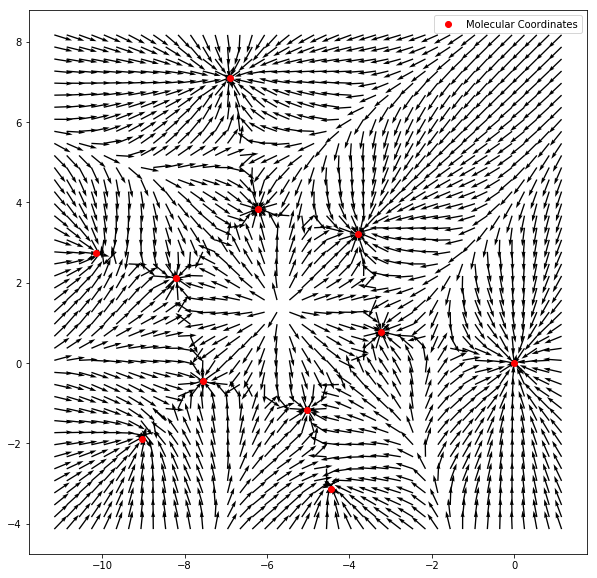

In [7]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.figure(figsize=(10,10))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=30)
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()

In [8]:
print(rot_proj_gradients[:,1])
print(grid_2d)

[ 0.72091656  0.68034089  0.62785585 ... -0.69419164 -0.69700773
 -0.69671635]
[[-11.15737795  -4.13120126]
 [-11.15737795  -3.83120126]
 [-11.15737795  -3.53120126]
 ...
 [  1.14262205   7.56879874]
 [  1.14262205   7.86879874]
 [  1.14262205   8.16879874]]


## Generation of a Contour Plot 

Contour plots convert a 3D function to 2D and are usued to represent the change in a specific axis given the other variables are held constant. Each contour line is a *level curve* which represents points that share the same z coordinate. 

In [53]:
coord1 = coord[0] 
coord2 = coord[1]
coord3 = coord[2]

v1, v2 = coord2 - coord1, coord3 - coord1
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)


'''
x= grid_2d[:,0]
y = grid_2d[:,1]
X, Y = np.meshgrid(x, y)
Z = mol.compute_density(grid_plane)
gradients = Z
proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal

print(Z)


plt.figure(figsize=(10,10))
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.contour(X,Y,Z)
#plt.contourf(X,Y,Z, cmap='Reds')

plt.show()
'''

'\nx= grid_2d[:,0]\ny = grid_2d[:,1]\nX, Y = np.meshgrid(x, y)\nZ = mol.compute_density(grid_plane)\ngradients = Z\nproj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal\n\nprint(Z)\n\n\nplt.figure(figsize=(10,10))\nplt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")\nplt.legend()\nplt.contour(X,Y,Z)\n#plt.contourf(X,Y,Z, cmap=\'Reds\')\n\nplt.show()\n'

In [9]:
def plotVectorFieldOverPlane(coord1,coord2,coord3,step_size=0.32, title=''):
    """
    PARAMETERS
    
    coord1 : np.ndarray(3,)
        First point on plane 
        
    coord2 : np.ndarray(3,) 
        Second Point on plane
    
    coord3 : np.ndarray(3,)
        Third Point on Plane
    
    vectorFunct : callabel() 
        Vector Field that inputs 3D point to 3D point 
    
    stepSize : float
        Step Size of 2D Affine Grid
    
    title : str
        Title
    
    color : str
        Color of Gradient Arrows  
    
    _rotate_3d(normal) : helper function
        this function consoliates the rotation matrix operation 
    """

    v1, v2 = coord2 - coord1, coord3 - coord1
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)

    a, b, c = normal
    
    def _rotate_3d(normal):
        """
        This function is intended to consolitate the rotate 
        and scale operation of the matrix
        """
        a,b,c = normal
        cos_theta = c
        sin_theta = np.sqrt(a**2.0 + b**2.0)
        u_1 = b / np.sqrt(a**2.0 + b**2.0)
        u_2 = -a / np.sqrt(a**2.0 + b**2.0)
        rot = np.array([
            [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
            [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
            [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
            
        ])
        return rot
    _rotate_3d(normal)
    rot_coords = np.dot(rot, (coord - coord[0]).T).T


    l_bnd = np.min(rot_coords, axis=0) - 1
    u_bnd = np.max(rot_coords, axis=0) + 1
    print(l_bnd)
    
    x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
    y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
    grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)

    # Add zero z-axis and rotate it and translate it to the plane
    grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
    grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
    grid_plane += coord[0]
    
    vectorFunc = mol.compute_gradient(grid_plane)
    gradients = vectorFunc
    print(gradients)

    proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
    rot_proj_gradients = np.dot(rot, proj_gradients.T).T
    
    # Rotate Projected Plane.
    rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
    plt.figure(figsize=(10,10))
    plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=45)
    plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
    plt.legend()
    
    plt.title(title)
    plt.show()

    
    

[-11.15737795  -4.13120126  -1.00005684]
[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-1.04931053e-05  7.99884048e-04 -1.16055706e-08]
 [-8.37508916e-05  1.22474323e-03 -2.02612834e-08]
 ...
 [ 3.37264489e-08 -9.01586420e-06  1.84176696e-10]
 [ 3.25398635e-09 -7.02805652e-06  1.41053402e-10]
 [ 2.07112074e-09 -5.47775577e-06  1.08597246e-10]]


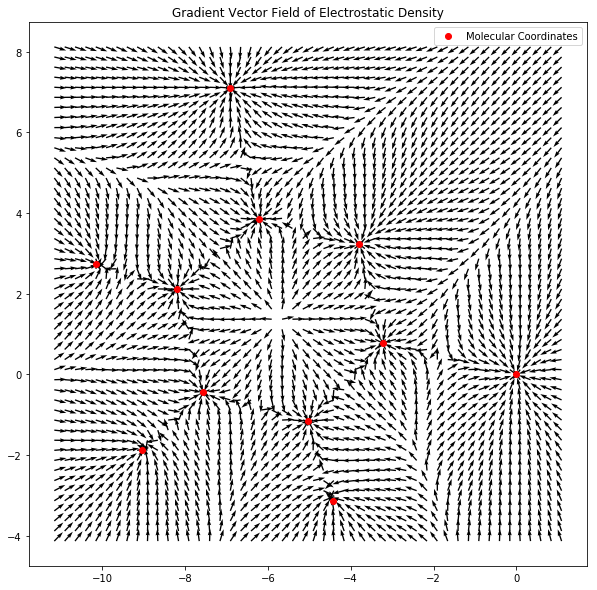

In [122]:
plotVectorFieldOverPlane(coord[0],coord[1],coord[2],step_size=0.25, title='Gradient Vector Field of Electrostatic Density')

In [77]:

coord1 = coord[0]
coord2 = coord[1]
coord3 = coord[2]

def plotScalarFunctionContourPlot(coord1, coord2, coord3,step_size=0.3):
    v1, v2 = coord1 - coord3, coord2 - coord3
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    print("Orthonormal : ")
    a, b, c = normal
    def _get_rotation_matrix_to_xy_plane(normal): 
        """
        This function is designed to consolidate a 2D rotate 
        operation, returning rot, which can then be used 
        to determine the rotated coordinates by computing the dot 
        product 
        """
        a,b,c = normal
        costheta = c
        sintheta = np.sqrt(a**2.0 + b**2.0)
        x = u_1 = b / np.sqrt(a**2.0 + b**2.0)
        y = u_2 = -a / np.sqrt(a**2.0 + b**2.0)

        cos, sin = np.cos(costheta), np.sin(sintheta)
        rot = np.matrix([[cos, sin], [-sin, cos]]) # 2D Rotate 

        return rot
    _get_rotation_matrix_to_xy_plane(normal)
    print("Rotation Operation: ")
    print(rot)

    rot_coords = np.dot(rot, (coord - coord[0]).T).T
    print("Rotation Coordinates: ")
    print(rot_coords)
    l_bnd = np.min(rot_coords, axis=0) - 1
    u_bnd = np.max(rot_coords, axis=0) + 1

    x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
    y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
    grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)
    

    grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
    grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
    grid_plane += coord[0]
    print("Grid Plane:")
    print(grid_plane)

    x = grid_2d[:,0]
    y = grid_2d[:,1]
    xy = np.meshgrid(grid_2d[:,0],grid_2d[:,1])
    
    scalarFunc = mol.compute_density(grid_plane)
          
    levels = np.array([0.001 * n * n for n in range(1000)])
    scalarFuncPlot = scalarFunc.reshape((len(x_grid), len(y_grid)), order="F")
    plt.figure(figsize=(10,10))
    plt.title("Contour Plot of Electrostatic Density")

    plt.contour(x_grid,y_grid,scalarFuncPlot, levels )

    plt.show()

Orthonormal : 
Rotation Operation: 
[[-6.97331320e-01  7.16748929e-01 -4.77061362e-05]
 [ 7.16748929e-01  6.97331321e-01  2.01453432e-05]
 [ 4.77061362e-05 -2.01453432e-05 -9.99999999e-01]]
Rotation Coordinates: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.90578162e+00  7.09758945e+00  3.32933254e-20]
 [-3.78908149e+00  3.22168550e+00  6.49732457e-21]
 [-7.55924902e+00 -4.46580843e-01 -2.63191882e-05]
 [-5.01995578e+00 -1.16084361e+00 -2.95672968e-05]
 [-8.20369267e+00  2.11132954e+00 -7.37073181e-07]
 [-3.23205529e+00  7.81105542e-01 -5.68426273e-05]
 [-6.21348886e+00  3.84534212e+00  3.37365785e-05]
 [-9.03609861e+00 -1.88352622e+00 -2.26066815e-05]
 [-4.43829811e+00 -3.13120126e+00 -4.03176841e-05]
 [-1.01573780e+01  2.74675040e+00 -8.11709351e-06]]
Grid Plane:
[[-1.31954229e-01 -8.56611497e+00  1.84489266e-04]
 [ 8.30704494e-02 -8.35691557e+00  1.90532869e-04]
 [ 2.98095128e-01 -8.14771618e+00  1.96576472e-04]
 ...
 [-3.23166990e-01  8.40867332e+00 -1.66595694e-04]
 [-1

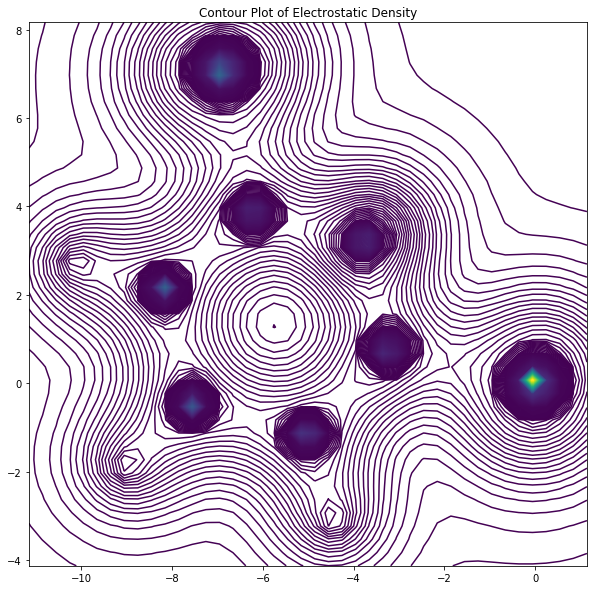

In [78]:
plotScalarFunctionContourPlot(coord1, coord2, coord3,step_size=0.3)

In [ ]:
print(scalarFunc)